In [1]:
# 사전훈련된 모델 사용  VGG16

In [1]:
from tensorflow import keras

In [7]:
# 특성 추출기
base_conv = keras.applications.vgg16.VGG16(
    include_top = False
    ,weights='imagenet'
    ,input_shape = (180,180,3)
)

In [ ]:
help(keras.applications.vgg16.VGG16)

In [8]:
base_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [9]:
import numpy as np

In [11]:
# 데이터셋은 "텐서플로4_비전시스템" 노트북에있는 데이터셋을 이용한다.
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    "/content/drive/MyDrive/test",
    image_size=(180, 180),
    batch_size=32)

Found 1000 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [13]:
# 레이블 추출
from tqdm import tqdm
def getFeatureAndLabels(dataset):
  all_feature = []
  all_labels = []
  for images, labels in tqdm(dataset):
    preprocessed_images = keras.applications.vgg16.preprocess_input(images)
    features =  base_conv(preprocessed_images)
    all_feature.append(features)
    all_labels.append(labels)
  return np.concatenate(all_feature), np.concatenate(all_labels)

In [14]:
train_feature,train_label = getFeatureAndLabels(train_dataset) 
validation_feature, validation_label = getFeatureAndLabels(validation_dataset)
test_feature, test_label = getFeatureAndLabels(test_dataset)

100%|██████████| 32/32 [06:13<00:00, 11.67s/it]


In [22]:
train_feature.shape, validation_feature.shape

((1000, 5, 5, 512), (500, 5, 5, 512))

In [23]:
train_feature.shape[1:]

(5, 5, 512)

In [28]:

# 밀집층 설계
inputs = keras.Input(shape = ( 5, 5, 512 ))
# inputs = keras.Input(shape = train_feature.shape[1:])
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

In [29]:
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = ([
    keras.callbacks.ModelCheckpoint('vgg16.keras', save_best_only=True )
]    
)
history = model.fit(train_feature,train_label,epochs=20,validation_data=(validation_feature,validation_label ), callbacks = callbacks )

Epoch 1/20
32/32 [==============================] - 1s 13ms/step - loss: 4.5326 - accuracy: 0.9020 - val_loss: 1.5107 - val_accuracy: 0.9580
Epoch 2/20
32/32 [==============================] - 0s 10ms/step - loss: 1.1644 - accuracy: 0.9740 - val_loss: 1.4768 - val_accuracy: 0.9620
Epoch 3/20
32/32 [==============================] - 0s 6ms/step - loss: 0.5115 - accuracy: 0.9860 - val_loss: 1.5943 - val_accuracy: 0.9560
Epoch 4/20
32/32 [==============================] - 0s 6ms/step - loss: 0.4367 - accuracy: 0.9860 - val_loss: 1.8467 - val_accuracy: 0.9540
Epoch 5/20
32/32 [==============================] - 0s 9ms/step - loss: 0.1317 - accuracy: 0.9910 - val_loss: 1.2773 - val_accuracy: 0.9620
Epoch 6/20
32/32 [==============================] - 0s 5ms/step - loss: 0.0274 - accuracy: 0.9980 - val_loss: 1.4186 - val_accuracy: 0.9700
Epoch 7/20
32/32 [==============================] - 0s 6ms/step - loss: 0.0244 - accuracy: 0.9970 - val_loss: 1.4403 - val_accuracy: 0.9720
Epoch 8/20
32/32 [

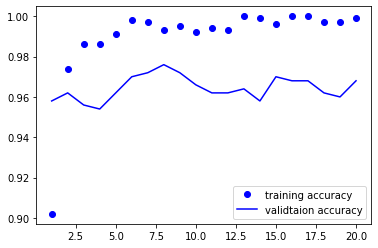

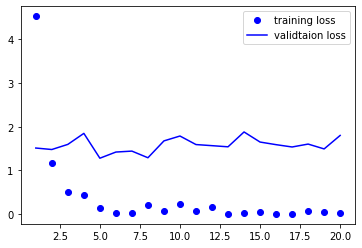

In [30]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'bo', label = 'training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'validtaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validtaion loss')
plt.legend()

In [31]:
test_model = keras.models.load_model('vgg16.keras')

In [32]:
test_model.evaluate(test_feature,test_label)

32/32 [==============================] - 0s 3ms/step - loss: 1.1682 - accuracy: 0.9630


[1.168202519416809, 0.9629999995231628]

In [38]:
# 가중치를 동결하고 사용
base_conv_freeze = keras.applications.VGG16(
    include_top = False
    ,weights='imagenet'
    ,input_shape = (180,180,3)
)
base_conv_freeze.trainable = False

In [36]:
# 동결하기 전의 가중치 리스트, 훈련가능한 가중치 개수
base_conv_freeze.trainable = True
len(base_conv_freeze.trainable_weights)

26

In [37]:
# 동결한 후 가중치 리스트, 훈련가능한 가중치 개수
base_conv_freeze.trainable = False
len(base_conv_freeze.trainable_weights)

0

In [39]:
# 데이터 제너러이터를 이용
data_generator = keras.Sequential(
    [
      keras.layers.RandomFlip('horizontal'),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.2)
    ]    
)
inputs = keras.layers.Input(shape = (180,180,3))
x = data_generator(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_conv_freeze(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256,activation = 'relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1,activation = 'sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = ([
    keras.callbacks.ModelCheckpoint('vgg16_weight_freeze.keras', save_best_only=True )
]    
)
history = model.fit(train_dataset,epochs=20,validation_data=(validation_dataset ), callbacks = callbacks )


Epoch 1/20
32/32 [==============================] - 9s 245ms/step - loss: 3.9004 - accuracy: 0.8620 - val_loss: 1.7673 - val_accuracy: 0.9580
Epoch 2/20
32/32 [==============================] - 8s 229ms/step - loss: 1.3291 - accuracy: 0.9430 - val_loss: 0.8934 - val_accuracy: 0.9700
Epoch 3/20
32/32 [==============================] - 8s 229ms/step - loss: 1.1541 - accuracy: 0.9450 - val_loss: 0.5375 - val_accuracy: 0.9700
Epoch 4/20
32/32 [==============================] - 8s 228ms/step - loss: 0.3198 - accuracy: 0.9620 - val_loss: 0.4273 - val_accuracy: 0.9680
Epoch 5/20
32/32 [==============================] - 8s 232ms/step - loss: 0.1916 - accuracy: 0.9740 - val_loss: 0.3866 - val_accuracy: 0.9760
Epoch 6/20
32/32 [==============================] - 7s 221ms/step - loss: 0.2542 - accuracy: 0.9730 - val_loss: 0.4418 - val_accuracy: 0.9600
Epoch 7/20
32/32 [==============================] - 8s 229ms/step - loss: 0.1684 - accuracy: 0.9770 - val_loss: 0.3813 - val_accuracy: 0.9740
Epoch 

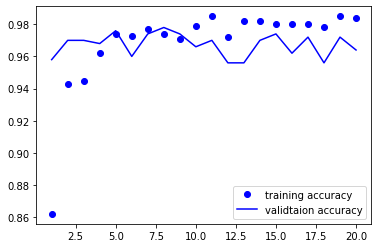

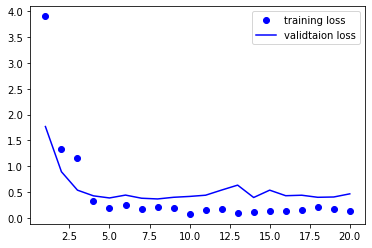

In [40]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'bo', label = 'training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'validtaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validtaion loss')
plt.legend()

In [41]:
test_model = keras.models.load_model('vgg16_weight_freeze.keras')
test_model.evaluate(test_dataset)

32/32 [==============================] - 5s 121ms/step - loss: 0.4448 - accuracy: 0.9740


[0.4447932839393616, 0.9739999771118164]

In [42]:
base_conv_freeze.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [45]:
base_conv_freeze.layers

In [47]:
# 마지막 4개층 까지 동결(마지막 4개만 활성화)
base_conv_freeze.trainable = True
for layer in base_conv_freeze.layers[:-4]:
  layer.trainable = False

In [48]:
model.compile(loss = 'binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate = 1e-5), metrics=['accuracy'])
callbacks = ([
    keras.callbacks.ModelCheckpoint('vgg16_weight_freeze_fineTurning.keras', save_best_only=True )
]    
)
history = model.fit(train_dataset,epochs=30,validation_data=(validation_dataset ), callbacks = callbacks )

Epoch 1/30
32/32 [==============================] - 11s 246ms/step - loss: 0.1176 - accuracy: 0.9830 - val_loss: 0.6940 - val_accuracy: 0.9540
Epoch 2/30
32/32 [==============================] - 8s 241ms/step - loss: 0.1032 - accuracy: 0.9840 - val_loss: 0.2973 - val_accuracy: 0.9700
Epoch 3/30
32/32 [==============================] - 8s 241ms/step - loss: 0.0658 - accuracy: 0.9850 - val_loss: 0.2877 - val_accuracy: 0.9700
Epoch 4/30
32/32 [==============================] - 8s 241ms/step - loss: 0.0114 - accuracy: 0.9940 - val_loss: 0.2702 - val_accuracy: 0.9740
Epoch 5/30
32/32 [==============================] - 8s 229ms/step - loss: 0.0295 - accuracy: 0.9910 - val_loss: 0.2834 - val_accuracy: 0.9780
Epoch 6/30
32/32 [==============================] - 8s 243ms/step - loss: 0.0364 - accuracy: 0.9930 - val_loss: 0.2516 - val_accuracy: 0.9740
Epoch 7/30
32/32 [==============================] - 8s 233ms/step - loss: 0.0285 - accuracy: 0.9890 - val_loss: 0.2534 - val_accuracy: 0.9720
Epoch

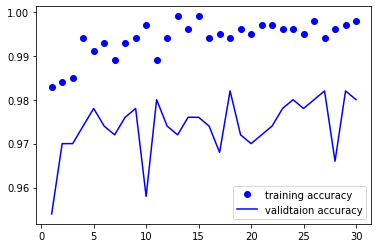

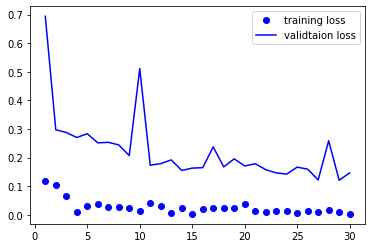

In [49]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, 'bo', label = 'training accuracy')
plt.plot(epochs, val_accuracy, 'b', label = 'validtaion accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'training loss')
plt.plot(epochs, val_loss, 'b', label = 'validtaion loss')
plt.legend()

In [50]:

test_model = keras.models.load_model('vgg16_weight_freeze_fineTurning.keras')
test_model.evaluate(test_dataset)

32/32 [==============================] - 4s 115ms/step - loss: 0.2389 - accuracy: 0.9740


[0.23892545700073242, 0.9739999771118164]